In [1]:
import numpy as np
import pandas as pd
import torch
from NashAgent_lib import *
from RAT_env import *
from NashRL import *
import matplotlib.pyplot as plt
from collections import Counter
from heuristic import run_heuristic

def predict_action(nn,states):
    if len(states.shape) > 2:
        B, A, D = states.shape  # B = batch size (10), A = agents (3), D = 255
        flat_states = states.view(B * A, D)  # Flatten to shape (30, 255)
        # Forward pass through action_net
        action_list = nn.forward(input=flat_states)
        # Reshape back to (10, 3, -1)
        action_list = action_list.view(B, A, -1)
        return action_list
    else:
        action_list = nn.forward(input=states) 

        return action_list

def evaluate_action_network(rat_env, action_network, n_episodes):
    
    action_network.eval()

    reward_buffer = []
    action_buffer = []
    for i in range(n_episodes):
        rat_env.reset()
        for t in range(0, 30):
            current_state, _, _ = rat_env.get_state()
            state = expand_list(current_state, rat_env.n_users)
            actions = torch.argmax(predict_action(action_network, state[:, :rat_env.n_stations]), dim=1)
            _, _, _, reward = rat_env.step(actions.detach())
            
            action_buffer.append(actions)
            reward_buffer.append(reward)
    
    return reward_buffer, action_buffer




def plot_reward(reward_buffer):
    n_runs = len(reward_buffer)
    n_agents = len(reward_buffer[0])
    
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))

    for i in range(n_agents):
        ax = axes[i // 5, i % 5]
        agent_rewards = np.array([reward_buffer[run][i] for run in range(n_runs)])
        
        ax.plot(range(n_runs), agent_rewards, label=f"User {i+1}")

        ax.set_title(f"User {i+1}")
        ax.set_xlabel("Step")
        ax.set_ylabel("Reward")
        ax.grid(True)
        ax.legend()

    fig.suptitle("Reward Evolution for Each User Across Runs", fontsize=16)
    plt.tight_layout()
    plt.show()

def plot_actions(actions_buffer):
    n_runs = len(actions_buffer)
    n_agents = len(actions_buffer[0])
    
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))

    for i in range(n_agents):
        ax = axes[i // 5, i % 5]
        agent_actions = np.array([int(torch.round(actions_buffer[run][i])) for run in range(n_runs)])
        ax.plot(range(n_runs), agent_actions, label=f"Agent {i+1}")

        ax.set_title(f"User {i+1}")
        ax.set_xlabel("Step")
        ax.set_ylabel("Station chosen")
        ax.grid(True)
        ax.legend()

    fig.suptitle("Stations Chosen by Each User Across Runs", fontsize=16)
    plt.tight_layout()
    plt.show()

def print_stats(rewards, actions,n_users):
    APs_chosen = [value.item() for action in actions for value in action if value.item() > 3]
    counted_aps = Counter(APs_chosen)
    LTEs_chosen = [value.item() for action in actions for value in action if value.item() <= 3]
    counted_ltes = Counter(LTEs_chosen)
    average_LTE_reward = np.mean([reward for reward, action in zip(rewards, actions) if any(value.item() <= 3 for value in action)])
    average_AP_reward = np.mean([reward for reward, action in zip(rewards, actions) if any(value.item() > 3 for value in action)])
    all_rewards = torch.cat(rewards).numpy()
    total_sn_chosen =  len(APs_chosen) + len(LTEs_chosen)
    disconnections = np.sum(all_rewards < 0)

    print(f"TEST RESULTS with {n_users} users in 150 episodes ({total_sn_chosen} stations chosen)")
    print("-----------------------------------------")
    print(f"{len(counted_aps)} APs chosen {len(APs_chosen)} times ({100 * len(APs_chosen) / (len(APs_chosen) + len(LTEs_chosen)):.2f}%) | {len(counted_ltes)} LTEs chosen {len(LTEs_chosen)} times ({100 * len(LTEs_chosen) / (len(APs_chosen) + len(LTEs_chosen)):.2f}%)")
    print(f"User disconnected {disconnections} times ({(disconnections / total_sn_chosen):.5f} %)")
    print(f"Average reward in LTEs: {average_LTE_reward:.3f} --> {average_LTE_reward * 600:.3f} Mb/s")
    print(f"Average reward in APs: {average_AP_reward:.3f} --> {average_AP_reward * 600:.3f} Mb/s")
    print("-----------------------------------------")
    print(f"LTEs chosen :", counted_ltes)
    print(f"APs chosen :", counted_aps)

import numpy as np
import matplotlib.pyplot as plt

def plot_episode_reward(reward_buffer, n_step):
    n_timesteps = len(reward_buffer)
    n_users = len(reward_buffer[0])
    n_episodes = n_timesteps // n_step

    rewards_np = np.array(reward_buffer)  # shape (timesteps, users)

    fig, axes = plt.subplots(2, 5, figsize=(12, 6))

    for user in range(n_users):
        ax = axes[user // 5, user % 5]
        user_rewards = rewards_np[:, user]

        episodes_avg = [
            np.mean(user_rewards[i*n_step:(i+1)*n_step])
            for i in range(n_episodes)
        ]

        ax.plot(range(n_episodes), episodes_avg, label=f"User {user+1}")
        ax.set_title(f"User {user+1}")
        ax.set_xlabel("Episode")
        ax.set_ylabel("Average Reward")
        ax.grid(True)
        ax.legend()

    fig.suptitle("Average Reward per Episode for Each User", fontsize=16)
    plt.tight_layout()
    plt.show()


Initialize enviroment

In [2]:
# Parameters for the Multi-RAT Network
area_width = 150
n_aps = 9
n_users = 10
n_steps = 30
rat_env = Multi_RAT_Network(area_width, n_users, n_aps, n_steps, plot=False)
# Simulation parameters
n_episodes = 100


### Evaluate DQN

In [3]:
action_network = PermInvariantQNN(n_users = rat_env.n_users, n_stations = rat_env.n_stations, out_dim= rat_env.n_stations, lat_dims=512, layers=1)
action_network.load_state_dict(torch.load("Action_Net.pt"))
rewards,actions = evaluate_action_network(rat_env, action_network, n_episodes)
print_stats(rewards, actions, n_users)


C:\Users\alvar\AppData\Local\Temp\ipykernel_10148\3852798495.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  action_network.load_state_dict(torch.load("Action_Net.pt"))


TEST RESULTS with 10 users in 150 episodes (30000 stations chosen)
-----------------------------------------
9 APs chosen 26249 times (87.50%) | 4 LTEs chosen 3751 times (12.50%)
User disconnected 0 times (0.00000 %)
Average reward in LTEs: 0.409 --> 245.657 Mb/s
Average reward in APs: 0.418 --> 250.595 Mb/s
-----------------------------------------
LTEs chosen : Counter({0: 2356, 2: 532, 3: 532, 1: 331})
APs chosen : Counter({8: 3786, 7: 3421, 5: 3012, 12: 2919, 4: 2861, 9: 2747, 11: 2729, 10: 2635, 6: 2139})


TEST RESULTS with 10 users in 150 episodes (45000 stations chosen)
9 APs chosen 37358 times (83.02%) | 4 LTEs chosen 7642 times (16.98%)
User disconnected 0 times (0.00000 %)
Average reward in LTEs: 0.408 --> 244.890 Mb/s
Average reward in APs: 0.415 --> 249.239 Mb/

Let's try tunning the hyperparameters to make it better, first gamma from 0.99 to 0.97 to 0.95

With 0.97 I would say it has improved:

TEST RESULTS with 10 users in 150 episodes (45000 stations chosen)
9 APs chosen 39479 times (87.73%) | 4 LTEs chosen 5521 times (12.27%)
User disconnected 0 times (0.00000 %)
Average reward in LTEs: 0.424 --> 254.645 Mb/s
Average reward in APs: 0.432 --> 259.291 Mb/s

Let's go with 0.95

### Evaluate Heuristic algorithm

In [4]:
# Simuation parameters
h_value = 1
p_switch = 0.8
m = 0
h_rewards, h_actions = run_heuristic(rat_env, n_episodes, h_value, p_switch, m)
print_stats(h_rewards, h_actions, n_users)


Simulaton progess:   0%|          | 0/100 [00:00<?, ?it/s]c:\Users\alvar\Documents\TELECO\cuarto\2 º Cuatri\Thesis\Nash_DQN_RAT\heuristic.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards_buffer.append(torch.tensor(lr))
Simulaton progess: 100%|██████████| 100/100 [00:27<00:00,  3.61it/s]


TEST RESULTS with 10 users in 150 episodes (30000 stations chosen)
-----------------------------------------
9 APs chosen 23934 times (79.78%) | 4 LTEs chosen 6066 times (20.22%)
User disconnected 180 times (0.00600 %)
Average reward in LTEs: 0.426 --> 255.697 Mb/s
Average reward in APs: 0.429 --> 257.645 Mb/s
-----------------------------------------
LTEs chosen : Counter({0: 1848, 1: 1744, 3: 1248, 2: 1226})
APs chosen : Counter({8: 3134, 5: 2978, 7: 2765, 6: 2654, 9: 2648, 4: 2522, 12: 2436, 11: 2417, 10: 2380})


### Plot results for DQN

Plot average_throughput per user and fairness

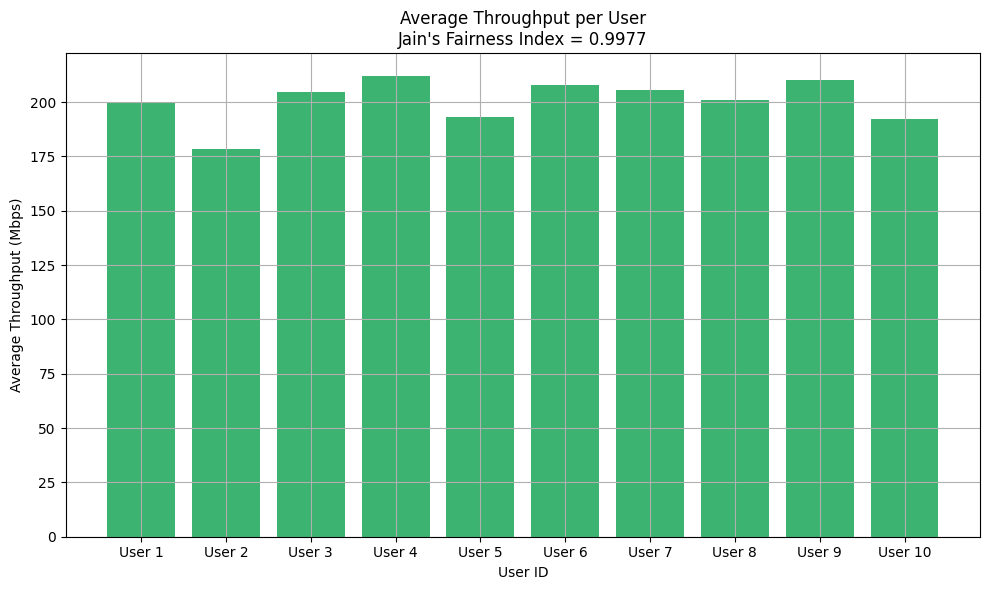

In [5]:
throughput_buffer = [
    [reward * rat_env.max_thr for reward in rewards]
    for rewards in rewards
]

# Step 3: Compute average throughput per user
n_users = len(throughput_buffer[0])
avg_throughput_per_user = [
    np.mean([throughput_buffer[episode][user] for episode in range(len(throughput_buffer))])
    for user in range(n_users)
]

# Step 4: Compute Jain's fairness index
numerator = (sum(avg_throughput_per_user)) ** 2
denominator = n_users * sum(x ** 2 for x in avg_throughput_per_user)
jain_index = numerator / denominator if denominator != 0 else 0

# Step 5: Plot average throughput per user
plt.figure(figsize=(10, 6))
plt.bar(range(n_users), avg_throughput_per_user, color='mediumseagreen')
plt.xlabel('User ID')
plt.xticks(ticks=range(n_users), labels=[f'User {i+1}' for i in range(n_users)])
plt.ylabel('Average Throughput (Mbps)')
plt.title(f'Average Throughput per User\nJain\'s Fairness Index = {jain_index:.4f}')
plt.grid(True)
plt.tight_layout()
plt.show()

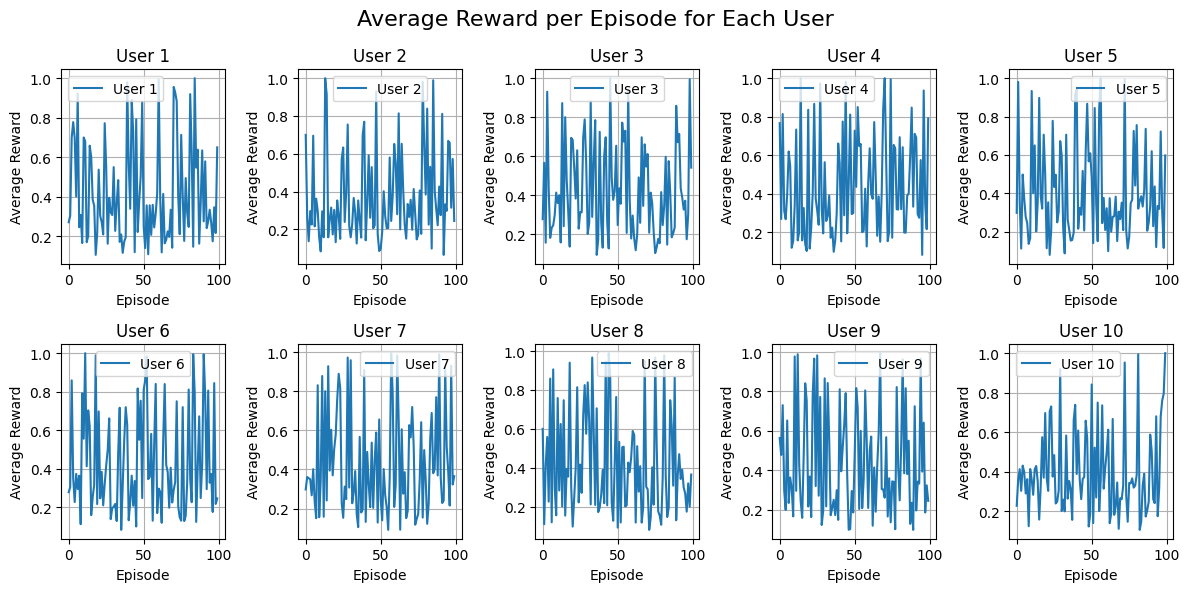

In [6]:
plot_episode_reward(rewards, n_steps)

In [7]:
## Just to check the variabliilty of the actoins and if they correspond to the rewards
#plot_actions(actions)
#plot_reward(rewards)

### Compare different algorithms results

Average Throughput and Fairness

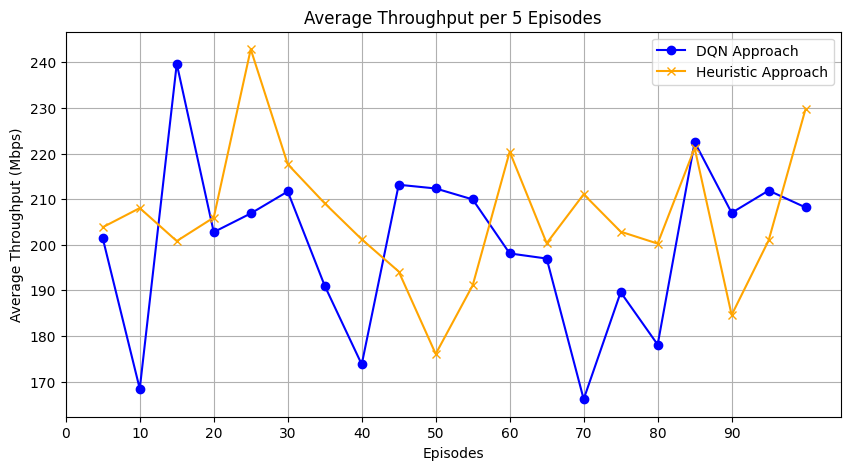

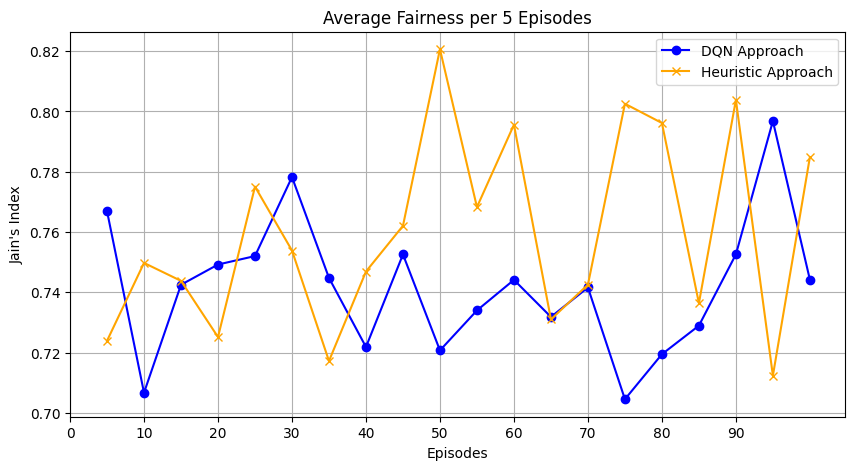

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def compute_avg_metrics(reward_data, n_steps, k, max_thr):
    avg_throughput = []
    avg_fairness = []
    throughput_accum = []
    fairness_accum = []

    for i, timestep_rewards in enumerate(reward_data):
        throughput = np.array(timestep_rewards) * max_thr
        throughput_accum.extend(throughput)
        numerator = (np.sum(throughput)) ** 2
        denominator = len(throughput) * np.sum(throughput ** 2)
        fairness = numerator / denominator if denominator != 0 else 0
        fairness_accum.append(fairness)
        if (i + 1) % (n_steps * k) == 0:
            avg_throughput.append(np.mean(throughput_accum))
            avg_fairness.append(np.mean(fairness_accum))
            throughput_accum = []
            fairness_accum = []
    
    return avg_throughput, avg_fairness

k = 5

episode_avg_throughput, episode_avg_fairness = compute_avg_metrics(rewards, n_steps, k, rat_env.max_thr)
episode_avg_throughput_h, episode_avg_fairness_h = compute_avg_metrics(h_rewards, n_steps, k, rat_env.max_thr)

x_vals = [(i + 1) * k for i in range(len(episode_avg_throughput))]

plt.figure(figsize=(10, 5))
plt.plot(x_vals, episode_avg_throughput, color='blue', marker='o', label='DQN Approach')
plt.plot(x_vals, episode_avg_throughput_h, color='orange', marker='x', label='Heuristic Approach')
plt.xlabel(f'Episodes')
plt.xticks(np.arange(0,100,10))
plt.ylabel('Average Throughput (Mbps)')
plt.title(f'Average Throughput per {k} Episodes')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(x_vals, episode_avg_fairness, color='blue', marker='o', label="DQN Approach")
plt.plot(x_vals, episode_avg_fairness_h, color='orange', marker='x', label="Heuristic Approach")
plt.xlabel(f'Episodes')
plt.xticks(np.arange(0,100,10))

plt.ylabel("Jain's Index")
plt.title(f"Average Fairness per {k} Episodes")
plt.grid(True)
plt.legend()
plt.show()


Congestion analysis: % of users connected to top 4 busy stations

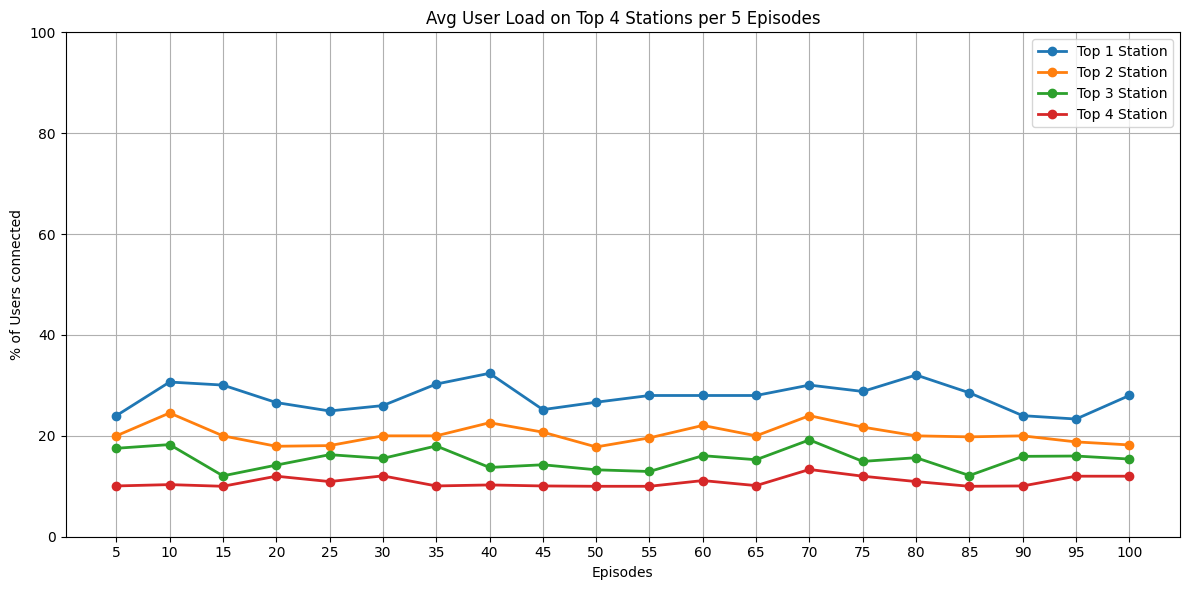

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

def plot_station_load(actions, n_steps, max_episodes=None, k=1, top_k=4):
    n_users = rat_env.n_users
    n_timesteps = len(actions)
    total_episodes = n_timesteps // n_steps
    n_episodes = min(max_episodes or total_episodes, total_episodes)

    grouped_episode_count = n_episodes // k
    top_k_percentages = [[] for _ in range(top_k)]

    for group in range(grouped_episode_count):
        group_top_k = [[] for _ in range(top_k)]

        for ep in range(group * k, (group + 1) * k):
            ep_start = ep * n_steps
            ep_end = (ep + 1) * n_steps

            for t in range(ep_start, ep_end):
                station_counts = Counter(a.item() for a in actions[t])
                top_k_counts = station_counts.most_common(top_k)

                for i in range(top_k):
                    if i < len(top_k_counts):
                        percent = (top_k_counts[i][1] / n_users) * 100
                    else:
                        percent = 0.0
                    group_top_k[i].append(percent)

        for i in range(top_k):
            top_k_percentages[i].append(np.mean(group_top_k[i]))

    x_vals = [(i + 1) * k for i in range(grouped_episode_count)]
    colors = plt.cm.tab10.colors

    plt.figure(figsize=(12, 6))

    for i in range(top_k):
        usage = top_k_percentages[i]
        avg = np.mean(usage)
        std = np.std(usage)

        plt.plot(x_vals, usage, marker='o', linewidth=2, color=colors[i % len(colors)], label=f'Top {i+1} Station')

    plt.xlabel('Episodes')
    plt.xticks(x_vals)
    plt.ylabel('% of Users connected')
    plt.title(f'Avg User Load on Top {top_k} Stations per {k} Episodes')
    plt.ylim(0, 100)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_station_load(actions, n_steps, max_episodes=100, k=5, top_k=4)


Proportion of users connected to LTE vs Wifi over time

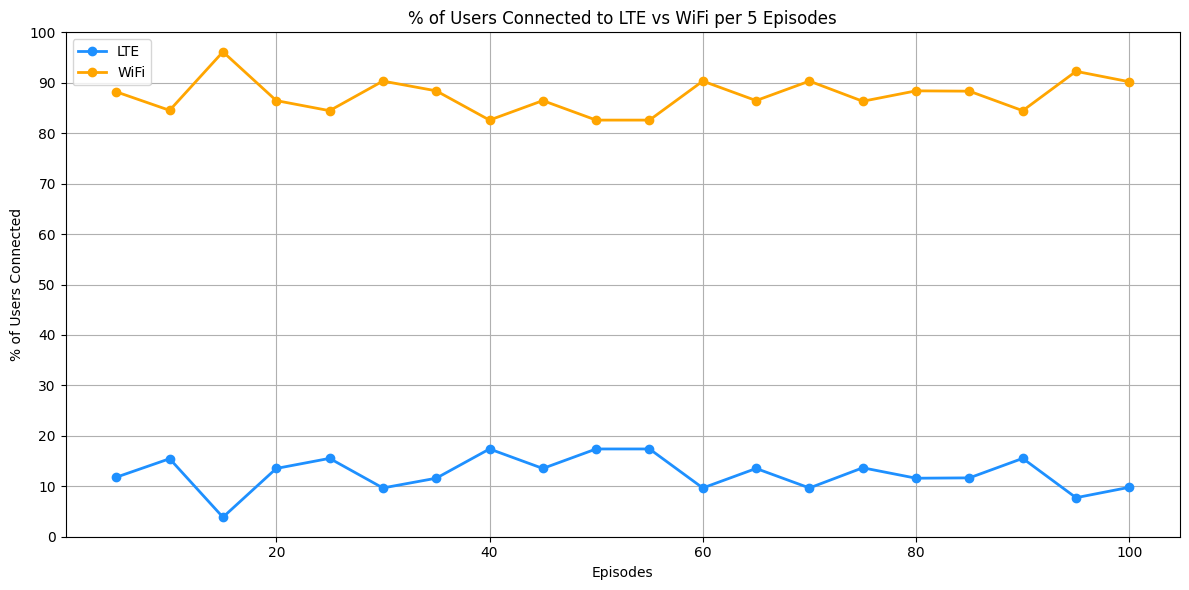

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def plot_rat_split(actions, n_steps, max_episodes=None, k=1):
    n_users = rat_env.n_users
    lte_station_ids = list(range(rat_env.n_ltesn))
    ap_station_ids = list(range(rat_env.n_ltesn, rat_env.n_stations))

    n_timesteps = len(actions)
    total_episodes = n_timesteps // n_steps
    n_episodes = min(max_episodes or total_episodes, total_episodes)
    grouped_episode_count = n_episodes // k

    lte_percent_per_group = []
    ap_percent_per_group = []

    for group in range(grouped_episode_count):
        lte_accum = []
        ap_accum = []

        for ep in range(group * k, (group + 1) * k):
            ep_start = ep * n_steps
            ep_end = (ep + 1) * n_steps

            for t in range(ep_start, ep_end):
                station_counts = Counter(a.item() for a in actions[t])

                lte_connected = sum(station_counts.get(st_id, 0) for st_id in lte_station_ids)
                ap_connected = sum(station_counts.get(st_id, 0) for st_id in ap_station_ids)

                lte_percent = (lte_connected / n_users) * 100
                ap_percent = (ap_connected / n_users) * 100

                lte_accum.append(lte_percent)
                ap_accum.append(ap_percent)

        lte_percent_per_group.append(np.mean(lte_accum))
        ap_percent_per_group.append(np.mean(ap_accum))

    x_vals = [(i + 1) * k for i in range(grouped_episode_count)]

    plt.figure(figsize=(12, 6))
    plt.plot(x_vals, lte_percent_per_group, label='LTE', color='dodgerblue', linewidth=2, marker='o')
    plt.plot(x_vals, ap_percent_per_group, label='WiFi', color='orange', linewidth=2, marker='o')

    plt.xlabel(f'Episodes')
    plt.ylabel('% of Users Connected')
    plt.yticks(np.arange(0, 101, 10))
    plt.title(f'% of Users Connected to LTE vs WiFi per {k} Episodes')
    plt.ylim(0, 100)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_rat_split(actions, n_steps, max_episodes=100, k=5)

Number of switches

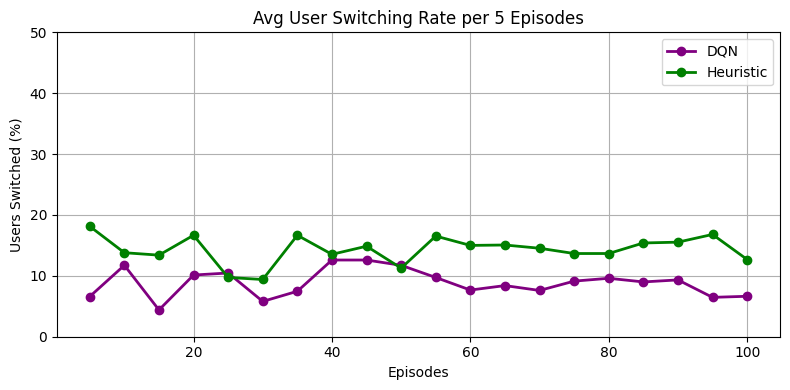

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_switching(actions, h_actions, n_steps, max_episodes=None, k=1):
    def compute_switch_percentages(action_seq):
        n_users = rat_env.n_users
        user_connections = [[a.item() for a in action] for action in action_seq]
        switch_percentages = []
        for t in range(1, len(user_connections)):
            prev = user_connections[t - 1]
            curr = user_connections[t]
            switches = sum(1 for i in range(n_users) if prev[i] != curr[i])
            switch_percentages.append((switches / n_users) * 100)
        return switch_percentages

    dqn_switch = compute_switch_percentages(actions)
    heuristic_switch = compute_switch_percentages(h_actions)

    total_episodes = len(actions) // n_steps
    n_episodes = min(max_episodes or total_episodes, total_episodes)
    grouped_episode_count = n_episodes // k

    def aggregate_switch(switch_list):
        result = []
        for group in range(grouped_episode_count):
            group_switch = []
            for ep in range(group * k, (group + 1) * k):
                start = ep * n_steps
                end = (ep + 1) * n_steps
                group_switch.extend(switch_list[start:end])
            result.append(np.mean(group_switch))
        return result

    dqn_grouped = aggregate_switch(dqn_switch)
    heuristic_grouped = aggregate_switch(heuristic_switch)
    x_vals = [(i + 1) * k for i in range(grouped_episode_count)]

    plt.figure(figsize=(8,4))
    plt.plot(x_vals, dqn_grouped, color='purple', linewidth=2, marker='o', label='DQN')
    plt.plot(x_vals, heuristic_grouped, color='green', linewidth=2, marker='o', label='Heuristic')

    plt.xlabel(f'Episodes')
    plt.ylabel('Users Switched(%)')
    plt.title(f'Avg User Switching Rate per {k} Episodes')
    plt.grid(True)
    plt.ylim(0, 50)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_switching(actions, h_actions, n_steps, max_episodes=100, k=5)